<a href="https://www.kaggle.com/code/yunusemreturkoglu/anti-money-laundering-vis-by-shap?scriptVersionId=162722374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

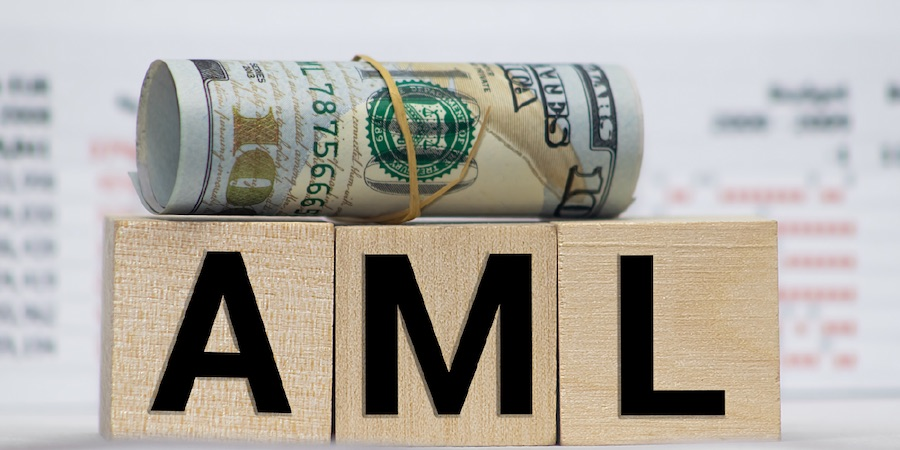

# <span style="font-family:cursive;">WHAT IS ANTI MONEY LAUNDERING ? </span>
Anti money laundering (AML) refers to the web of laws, regulations, and procedures aimed at uncovering efforts to disguise illicit funds as legitimate income. Money laundering seeks to conceal crimes ranging from small-time tax evasion and drug trafficking to public corruption and the financing of groups designated as terrorist organizations.


AML legislation was a response to the growth of the financial industry, the lifting of international capital controls and the growing ease of conducting complex chains of financial transactions.

A high-level United Nations panel has estimated annual money laundering flows at $1.6 trillion, accounting for 2.7% of global GDP in 2020.


# Description of Dataset

 * customer_id    : Unique id for customers
 * credit_debit   : Transaction(debit or credit)
 * cpcc           : Country which transaction was made
 * risk    : transaction status
 * type : transaction type(cash, cheque, wire

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, GridSearchCV,train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [2]:
df_data = pd.read_excel('/kaggle/input/anti-money-laundering/Data for assignment.xlsx')
df_country = pd.read_excel('/kaggle/input/anti-money-laundering/Data for assignment.xlsx',sheet_name = 'country_risk')
df_country.columns = ['CPCC','risk']
df1 = df_data.merge(df_country,on='CPCC')
df_product = pd.read_excel('/kaggle/input/anti-money-laundering/Data for assignment.xlsx',sheet_name='product_type')
df_product.columns = ['product_type','type']
df_ = df1.merge(df_product,on='product_type')
df_.columns = [col.lower() for col in df_.columns]
df = df_.copy()
df.head()
df.drop("product_type", axis=1, inplace=True)
df.dropna(inplace=True)
df = df.loc[df['amount']>0]
df['risk'] = df['risk'].map({"Y":1, "N":0})
df.head()


,customer_id,credit_debit,amount,cpcc,risk,type
0,7972,Credit,4763.00,FI,0,WIRE
1,4824,Credit,5437.00,FI,0,WIRE
2,5908,Debit,3420.00,FI,0,WIRE
3,9814,Debit,6432.00,FI,0,WIRE
4,9558,Credit,8005.00,FI,0,WIRE


In [3]:
# Creating a function for controling dataframe
def check_data(df):
    print('HEAD {0}'.format(df.head()))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print('TAIL {0}'.format(df.tail()))
    print('SHAPE: {0}'.format(df.shape))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print('INFO: {0}'.format(df.info()))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print('COLUMNS: {0}'.format(df.columns))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print('DESCRIBE {0}'.format(df.describe().T))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print("ISNULL {0}".format(df.isnull().sum()))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

In [4]:
check_data(df)

HEAD    customer_id credit_debit  amount cpcc  risk  type
0         7972       Credit 4763.00   FI     0  WIRE
1         4824       Credit 5437.00   FI     0  WIRE
2         5908        Debit 3420.00   FI     0  WIRE
3         9814        Debit 6432.00   FI     0  WIRE
4         9558       Credit 8005.00   FI     0  WIRE
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
TAIL         customer_id credit_debit  amount cpcc  risk    type
159686         7204       Credit 6436.00   MA     0  CHEQUE
159687          684        Debit 1214.00   TH     0  CHEQUE
159688          641       Credit 8365.00   LR     0  CHEQUE
159689          517       Credit 2251.00   LR     0  CHEQUE
159690          917        Debit 3177.00   LR     0  CHEQUE
SHAPE: (158582, 6)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
<class 'pandas.core.frame.DataFrame'>
Int64Index: 158582 entries, 0 to 159690
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   158582 non-n

In [5]:
# Classification of users according to the their operations 
custom_list = []
def checking_customers_operations(dataframe, col):
    IQR_tran = dataframe[col].value_counts().quantile(0.75) - dataframe[col].value_counts().quantile(0.25)
    value = dataframe[col].value_counts()
    for idx, count in value.items():
        if count >= dataframe[col].value_counts().quantile(0.75)+IQR_tran:
            custom_list.append(idx)
checking_customers_operations(df, "customer_id")

df["cus_stat"] = df["customer_id"].apply(lambda x: "dangerous" if x in custom_list else "not_dangerous")
df["cus_stat"].value_counts()

not_dangerous    141502
dangerous         17080
Name: cus_stat, dtype: int64

In [6]:
# Creating new customers's list who make an operations risky countries and their neigbors
# (PF(r), WS, TO, CK, FJ, NC ),(TL(r), CX), (YT(r), KM), (RO(r), MD, BG, XS, HU)
list_dangerous_id = []
def checking_customer_id_neigbor(dataframe, country, neig):
    for col in dataframe["customer_id"].loc[dataframe["cpcc"] == country].unique():
        if col in dataframe["customer_id"].loc[dataframe["cpcc"] == neig].unique():
            list_dangerous_id.append(col)
    return list_dangerous_id

checking_customer_id_neigbor(df, "PF", "WS")
checking_customer_id_neigbor(df, "PF", "TO")
checking_customer_id_neigbor(df, "PF", "CK")
checking_customer_id_neigbor(df, "PF", "FJ")
checking_customer_id_neigbor(df, "PF", "NC")
checking_customer_id_neigbor(df, "TL", "CX")
checking_customer_id_neigbor(df, "YT", "KM")
checking_customer_id_neigbor(df, "RO", "MD")
checking_customer_id_neigbor(df, "RO", "BG")
checking_customer_id_neigbor(df, "RO", "XS")
checking_customer_id_neigbor(df, "RO", "HU")
print(list_dangerous_id)

[907, 657, 577, 639, 923, 567, 815, 892, 589, 600, 875, 611, 833]


In [7]:
# Creating Pivot_table 
table = pd.pivot_table(index = ["customer_id", 'risk', 'credit_debit'], columns=["type"], 
                      values="amount", aggfunc='mean', data=df).reset_index()
table.columns = [col.lower() for col in table.columns]
table.fillna(0, inplace=True)
table.head()

,customer_id,risk,credit_debit,cash,cheque,wire
0,0,0,Credit,3574.00,4341.67,4685.75
1,0,0,Debit,3885.20,3302.67,5345.00
2,1,0,Credit,5240.00,4560.00,3862.00
3,1,0,Debit,5485.00,5417.00,4205.00
4,2,0,Credit,4258.50,4525.60,4564.00


In [8]:
# Checking tha new dataframe table
check_data(table)

HEAD    customer_id  risk credit_debit    cash  cheque    wire
0            0     0       Credit 3574.00 4341.67 4685.75
1            0     0        Debit 3885.20 3302.67 5345.00
2            1     0       Credit 5240.00 4560.00 3862.00
3            1     0        Debit 5485.00 5417.00 4205.00
4            2     0       Credit 4258.50 4525.60 4564.00
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
TAIL        customer_id  risk credit_debit    cash  cheque    wire
21965         9997     0        Debit 3500.50 2796.67 2342.00
21966         9998     0       Credit    0.00 6040.00 6176.50
21967         9998     0        Debit 5884.00 6615.75 6350.60
21968         9999     0       Credit 4175.00 3598.67 3490.86
21969         9999     0        Debit 3420.00 3569.50 3640.75
SHAPE: (21970, 6)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21970 entries, 0 to 21969
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  --

In [9]:
table.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,21970.00,4692.90,2950.10,0.00,1896.00,4551.50,7269.75,9999.00
risk,21970.00,0.09,0.29,0.00,0.00,0.00,0.00,1.00
cash,21970.00,4487.22,2332.08,0.00,3560.00,4763.25,5921.92,158208.00
cheque,21970.00,4498.43,2090.28,0.00,3547.38,4765.00,5947.25,16795.00
wire,21970.00,4491.65,2397.08,0.00,3563.00,4758.25,5929.50,134929.00


# FEATURE ENGINEERING

In [10]:
# Customer's operation segmentation
custom_list_table = []
def checking_value_counts(df, col):
    value = table[col].value_counts()
    for idx, count in value.items():
        if count >= 3:
            custom_list_table.append(idx)

checking_value_counts(table,"customer_id")
len(custom_list_table)


table["cus_status"] = table["customer_id"].apply(lambda x: "dangerous" if x in custom_list_table else 'not_dangerous')
table.head()


,customer_id,risk,credit_debit,cash,cheque,wire,cus_status
0,0,0,Credit,3574.00,4341.67,4685.75,not_dangerous
1,0,0,Debit,3885.20,3302.67,5345.00,not_dangerous
2,1,0,Credit,5240.00,4560.00,3862.00,not_dangerous
3,1,0,Debit,5485.00,5417.00,4205.00,not_dangerous
4,2,0,Credit,4258.50,4525.60,4564.00,not_dangerous


In [11]:
# Creating new variables using mathematical realtions between "cash", "wire", "cheque"
table["total_amount"] = table["cash"] + table["wire"] + table["cheque"] 
table["wire_cheque_sum"] = table["wire"] + table["cheque"]
table["wire_cheque_minus"] = table["wire"] - table["cheque"]
table["wire_cash_sum"] = table["wire"] + table["cash"]
table["wire_cash_minus"] = table["wire"] - table["cash"]
table["cheque_cash_sum"] = table["cheque"] + table["cash"]
table["cheque_cash_minus"] = table["cheque"] - table["cash"]
table.head()



,customer_id,risk,credit_debit,cash,cheque,wire,cus_status,total_amount,wire_cheque_sum,wire_cheque_minus,wire_cash_sum,wire_cash_minus,cheque_cash_sum,cheque_cash_minus
0,0,0,Credit,3574.00,4341.67,4685.75,not_dangerous,12601.42,9027.42,344.08,8259.75,1111.75,7915.67,767.67
1,0,0,Debit,3885.20,3302.67,5345.00,not_dangerous,12532.87,8647.67,2042.33,9230.20,1459.80,7187.87,-582.53
2,1,0,Credit,5240.00,4560.00,3862.00,not_dangerous,13662.00,8422.00,-698.00,9102.00,-1378.00,9800.00,-680.00
3,1,0,Debit,5485.00,5417.00,4205.00,not_dangerous,15107.00,9622.00,-1212.00,9690.00,-1280.00,10902.00,-68.00
4,2,0,Credit,4258.50,4525.60,4564.00,not_dangerous,13348.10,9089.60,38.40,8822.50,305.50,8784.10,267.10


In [12]:
# Creating new variable using total_amount
IQR_table = table["total_amount"].quantile(0.75) - table["total_amount"].quantile(0.25)

table.loc[(table["total_amount"] >= (table['total_amount'].quantile(0.75)+ 1.5*IQR_table)), "total_amo_status"] = "level1"
table.loc[(table["total_amount"] < (table['total_amount'].quantile(0.75)+ 1.5*IQR_table)) &
          (table['total_amount'] >=table['total_amount'].quantile(0.75)-IQR_table), "total_amo_status"] = "level2"
table.loc[(table["total_amount"] < (table['total_amount'].quantile(0.75)-IQR_table)), "total_amo_status"] = "level3"

table.head()

,customer_id,risk,credit_debit,cash,cheque,wire,cus_status,total_amount,wire_cheque_sum,wire_cheque_minus,wire_cash_sum,wire_cash_minus,cheque_cash_sum,cheque_cash_minus,total_amo_status
0,0,0,Credit,3574.00,4341.67,4685.75,not_dangerous,12601.42,9027.42,344.08,8259.75,1111.75,7915.67,767.67,level2
1,0,0,Debit,3885.20,3302.67,5345.00,not_dangerous,12532.87,8647.67,2042.33,9230.20,1459.80,7187.87,-582.53,level2
2,1,0,Credit,5240.00,4560.00,3862.00,not_dangerous,13662.00,8422.00,-698.00,9102.00,-1378.00,9800.00,-680.00,level2
3,1,0,Debit,5485.00,5417.00,4205.00,not_dangerous,15107.00,9622.00,-1212.00,9690.00,-1280.00,10902.00,-68.00,level2
4,2,0,Credit,4258.50,4525.60,4564.00,not_dangerous,13348.10,9089.60,38.40,8822.50,305.50,8784.10,267.10,level2


In [13]:
list_dangerous_id

[907, 657, 577, 639, 923, 567, 815, 892, 589, 600, 875, 611, 833]

In [14]:
# New variables using cus_stat variable and list_dangerous_id

table.loc[(table['cus_status'] == "dangerous") & (table['customer_id'].apply(lambda x: x in list_dangerous_id)), "cus_dange_rate"] = "high"
table.loc[(table['cus_status'] == "not_dangerous") & (table['customer_id'].apply(lambda x: x in list_dangerous_id)), "cus_dange_rate"] = "mid"
table.loc[(table['cus_status'] == "dangerous") & (table['customer_id'].apply(lambda x: x not in list_dangerous_id)), "cus_dange_rate"] = "low"
table.loc[(table['cus_status'] == "not_dangerous") & (table['customer_id'].apply(lambda x: x not in list_dangerous_id)), "cus_dange_rate"] = "not"
table.cus_dange_rate.value_counts()

not     17354
low      4567
high       49
Name: cus_dange_rate, dtype: int64

In [15]:
# Creating separate threshold values for cash, wire, cheque variables and create new variables using them

def variables_using_thresholds(dataframe, col, col_name):
    IQR = dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
    dataframe.loc[dataframe[col] >= (dataframe[col].quantile(0.75) + IQR), col_name] = "risk"
    dataframe.loc[dataframe[col] < (dataframe[col].quantile(0.75) + IQR), col_name] = "not_risk"


variables_using_thresholds(table, "cash", "cash_status")
variables_using_thresholds(table, "cheque", "cheque_status")
variables_using_thresholds(table, "wire", "wire_status")

In [16]:
table.isnull().sum()

customer_id          0
risk                 0
credit_debit         0
cash                 0
cheque               0
wire                 0
cus_status           0
total_amount         0
wire_cheque_sum      0
wire_cheque_minus    0
wire_cash_sum        0
wire_cash_minus      0
cheque_cash_sum      0
cheque_cash_minus    0
total_amo_status     0
cus_dange_rate       0
cash_status          0
cheque_status        0
wire_status          0
dtype: int64

In [17]:
cat_cols = [col for col in table.columns if table[col].dtypes == "object"]
num_cols = [col for col in table.columns if table[col].dtypes != "object" and "customer_id" not in col]

In [18]:
cat_cols

['credit_debit',
 'cus_status',
 'total_amo_status',
 'cus_dange_rate',
 'cash_status',
 'cheque_status',
 'wire_status']

In [19]:
num_cols

['risk',
 'cash',
 'cheque',
 'wire',
 'total_amount',
 'wire_cheque_sum',
 'wire_cheque_minus',
 'wire_cash_sum',
 'wire_cash_minus',
 'cheque_cash_sum',
 'cheque_cash_minus']

# Visualizations

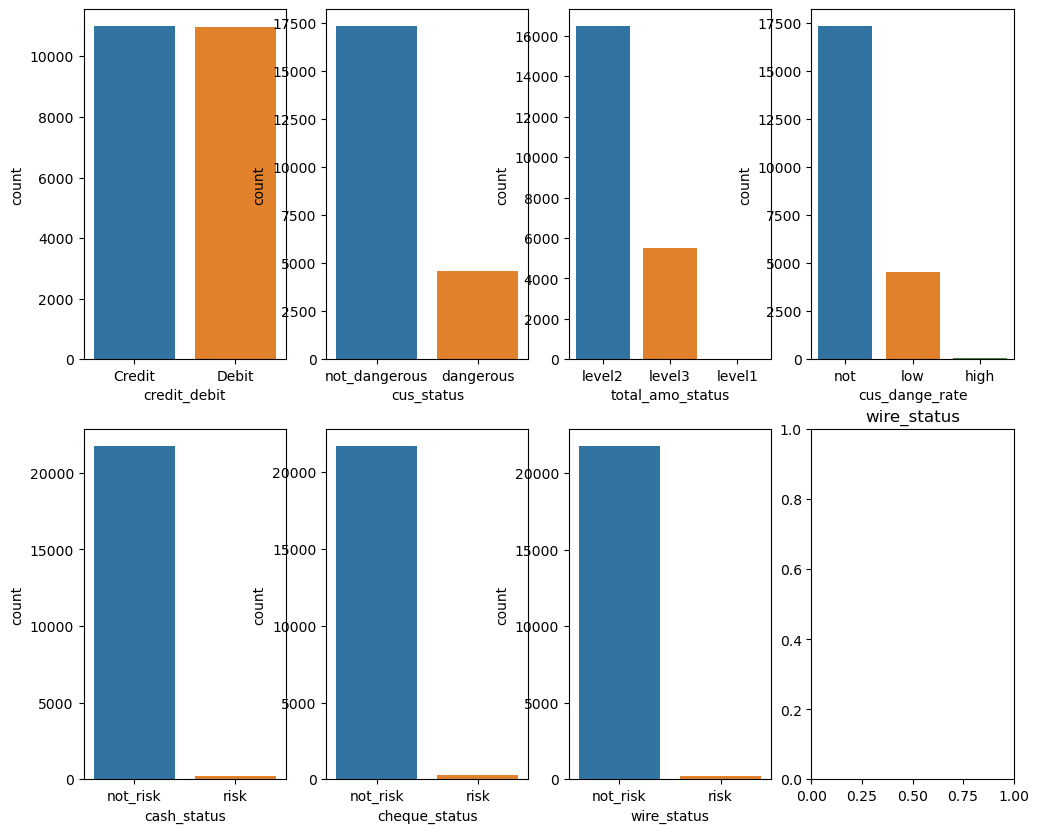

In [20]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(12,10))
axs = axs.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(x=col,data=table,ax=axs[i])
    plt.title(col)
plt.show()

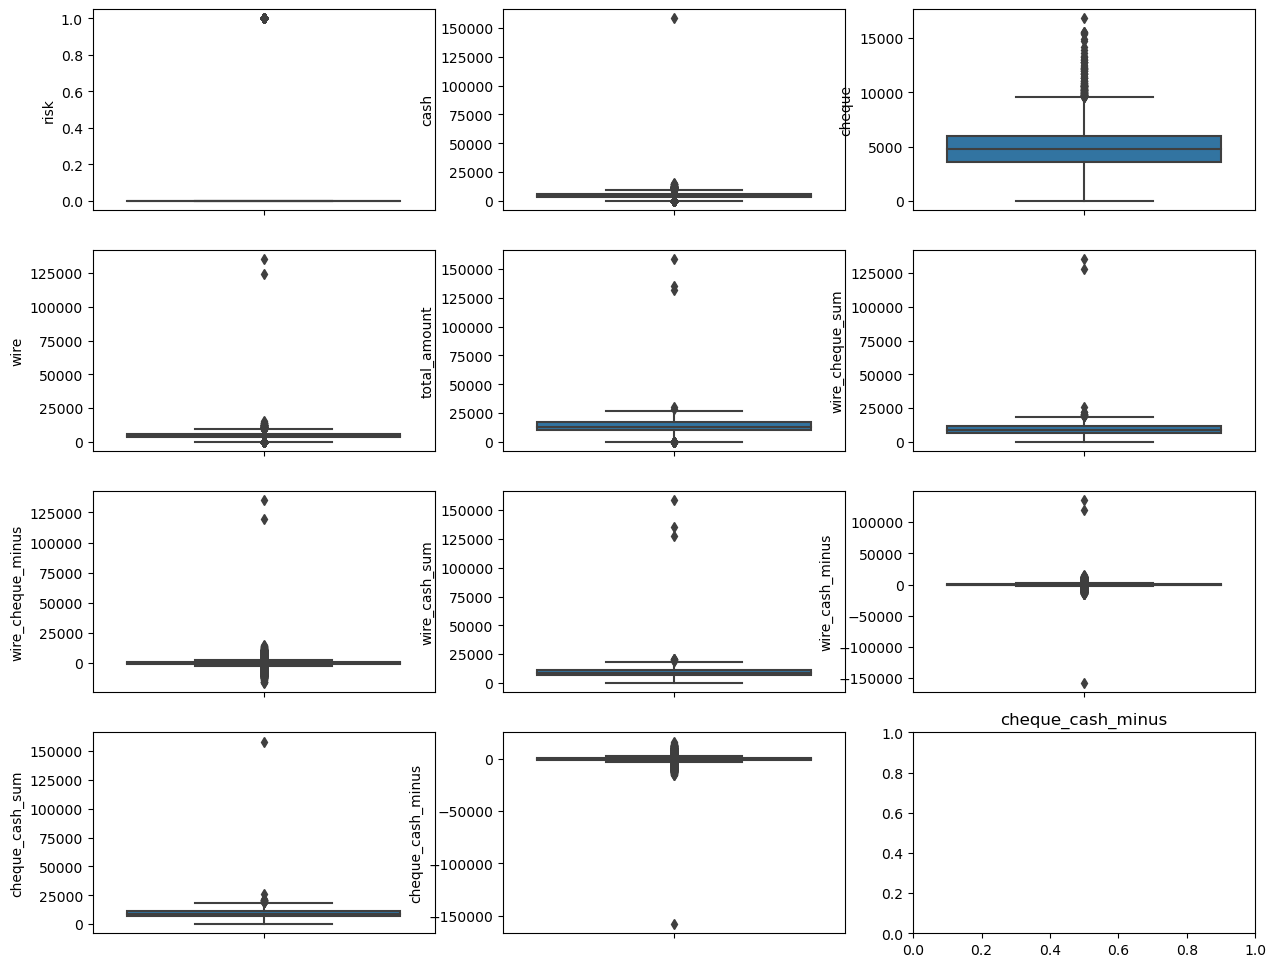

In [21]:
fig, axs = plt.subplots(nrows=4,ncols=3,figsize=(15,12))
axs = axs.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=col,data=table,ax=axs[i])
    plt.title(col)
plt.show()

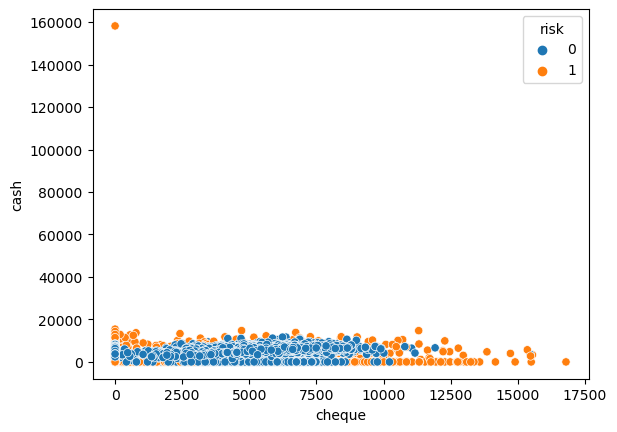

In [22]:
sns.scatterplot(x="cheque", y="cash", hue="risk", data=table)
plt.show()

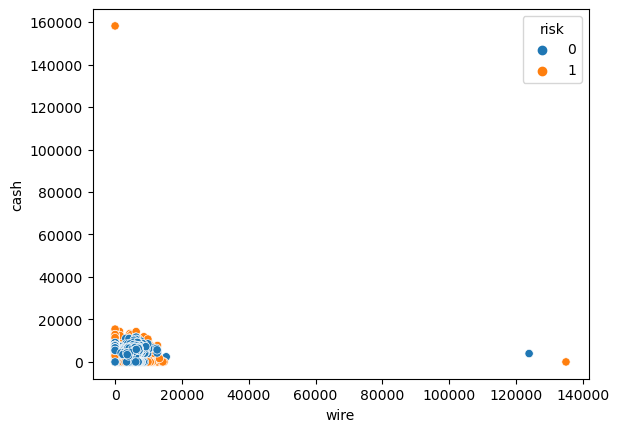

In [23]:
sns.scatterplot(x="wire", y="cash", hue='risk', data=table)
plt.show()

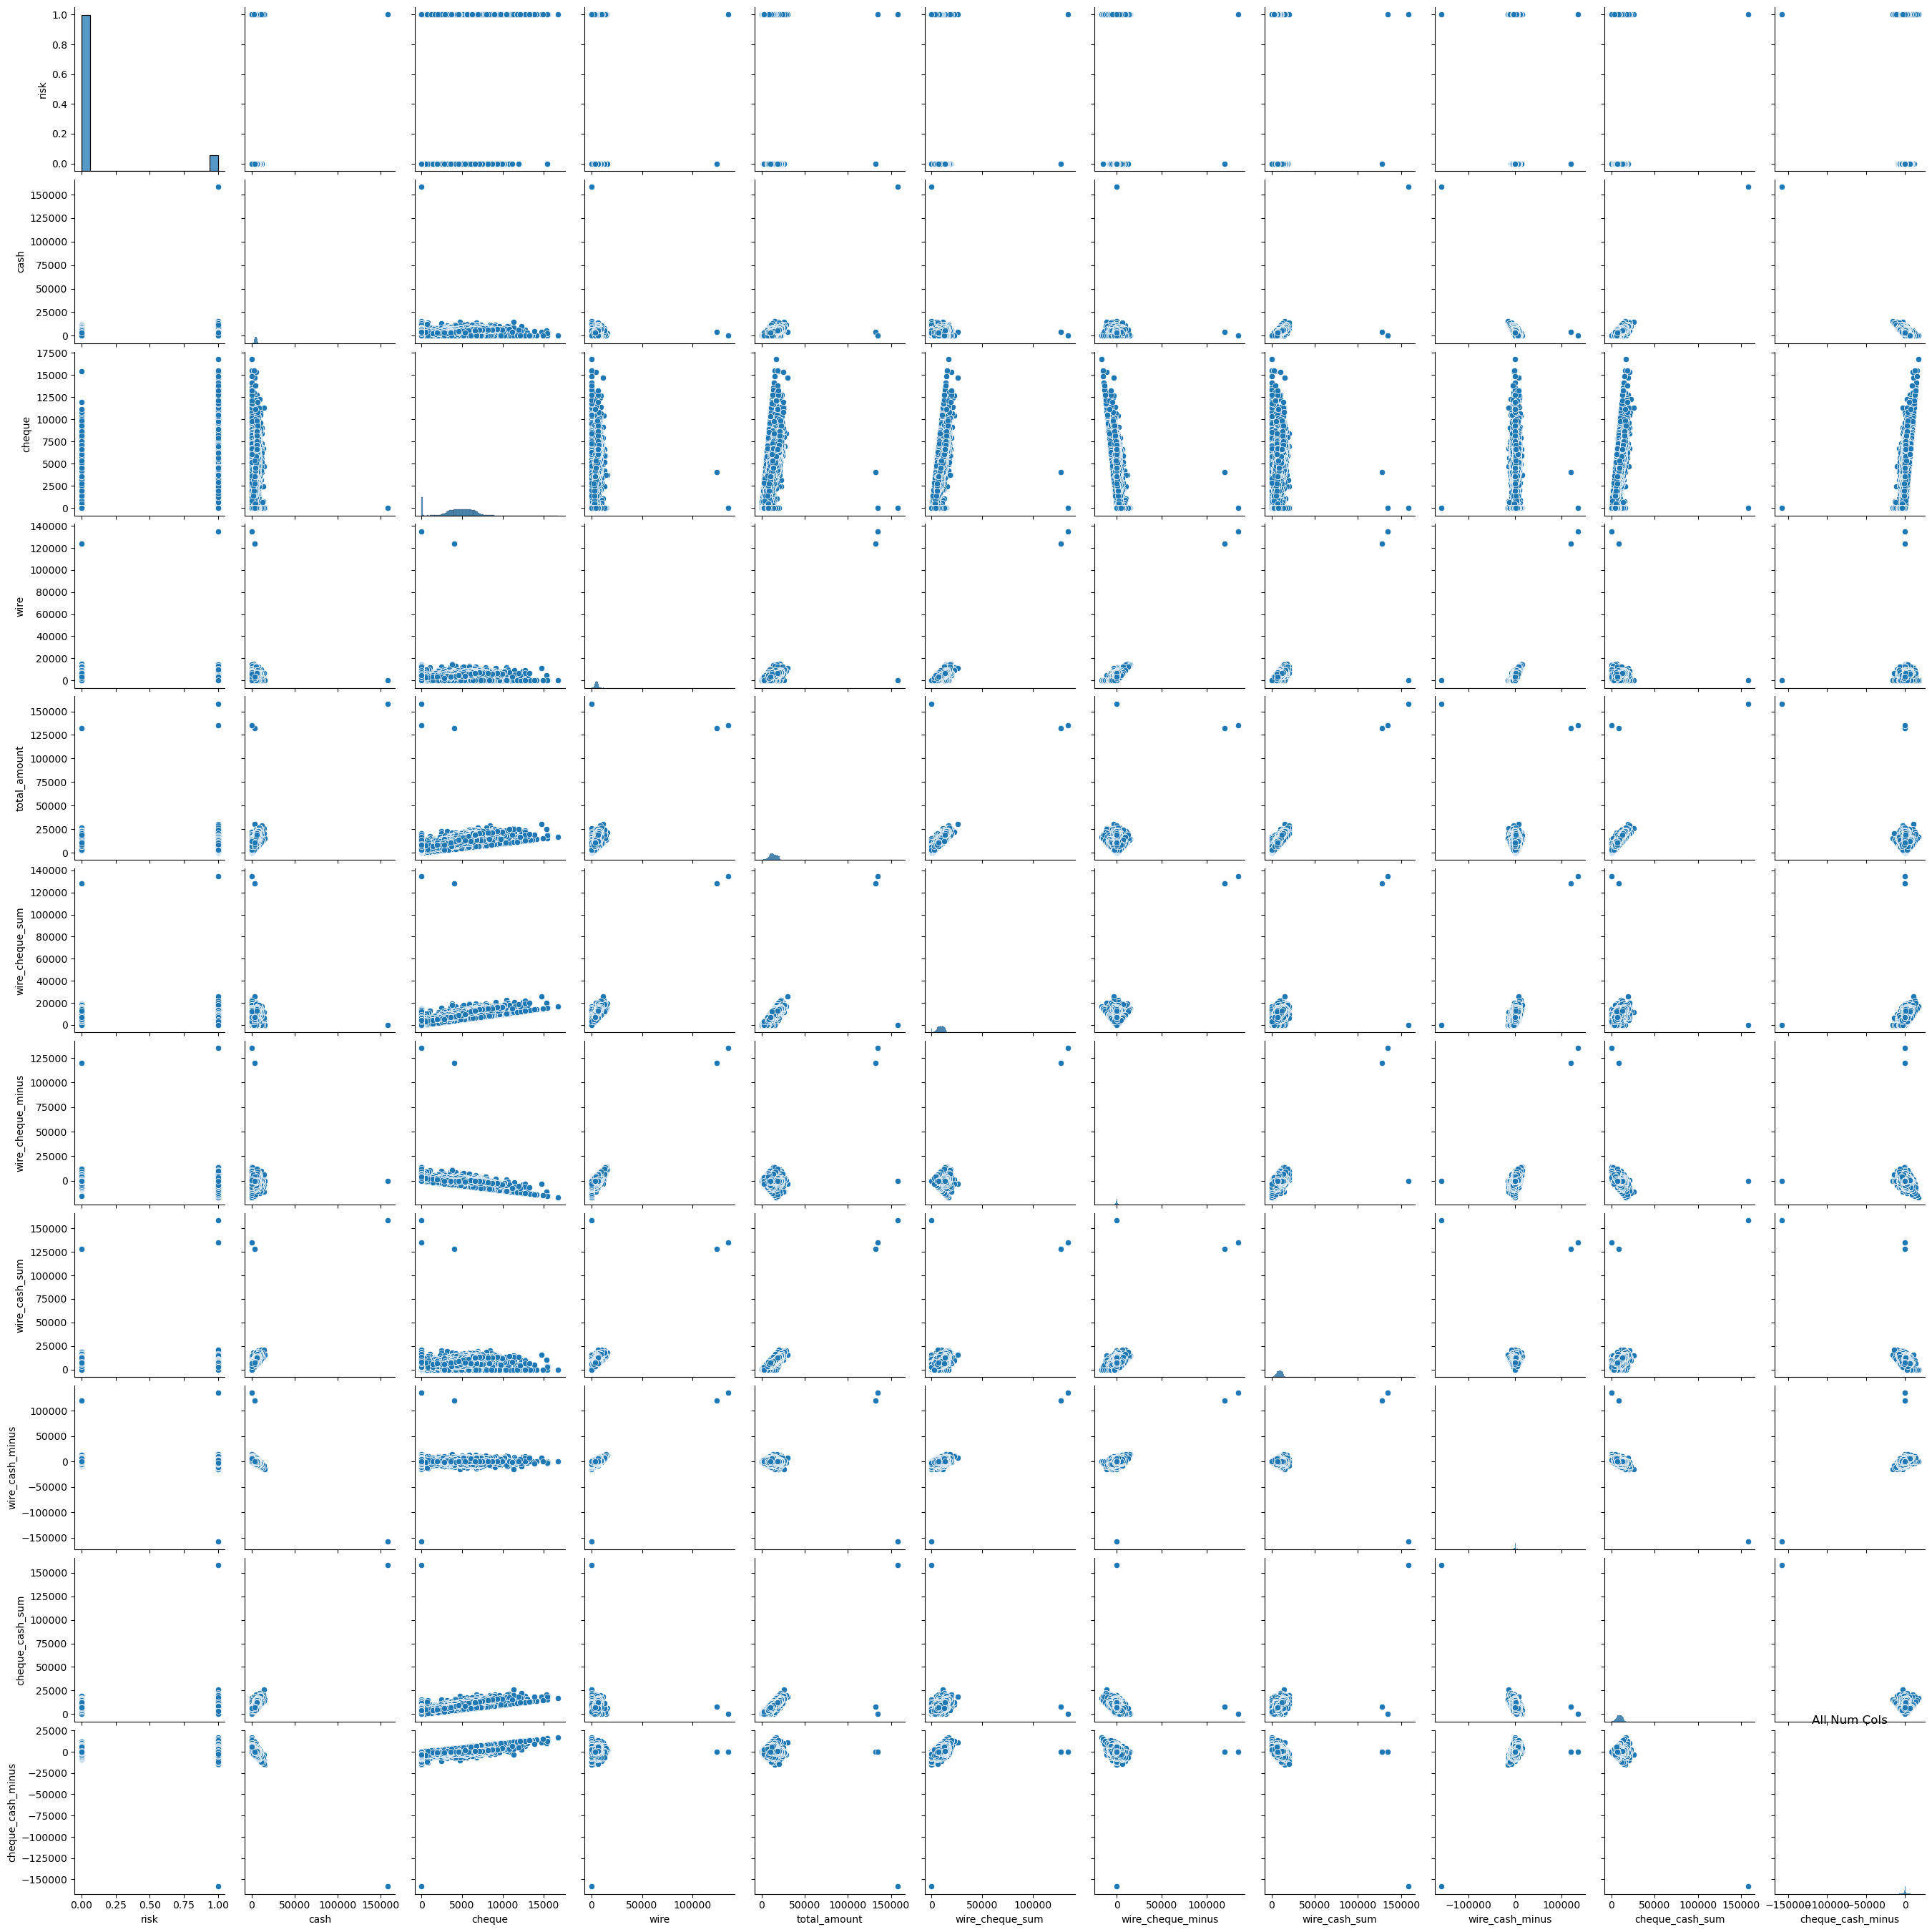

In [24]:
sns.pairplot(table[num_cols])
plt.title('All Num Cols')
plt.show()

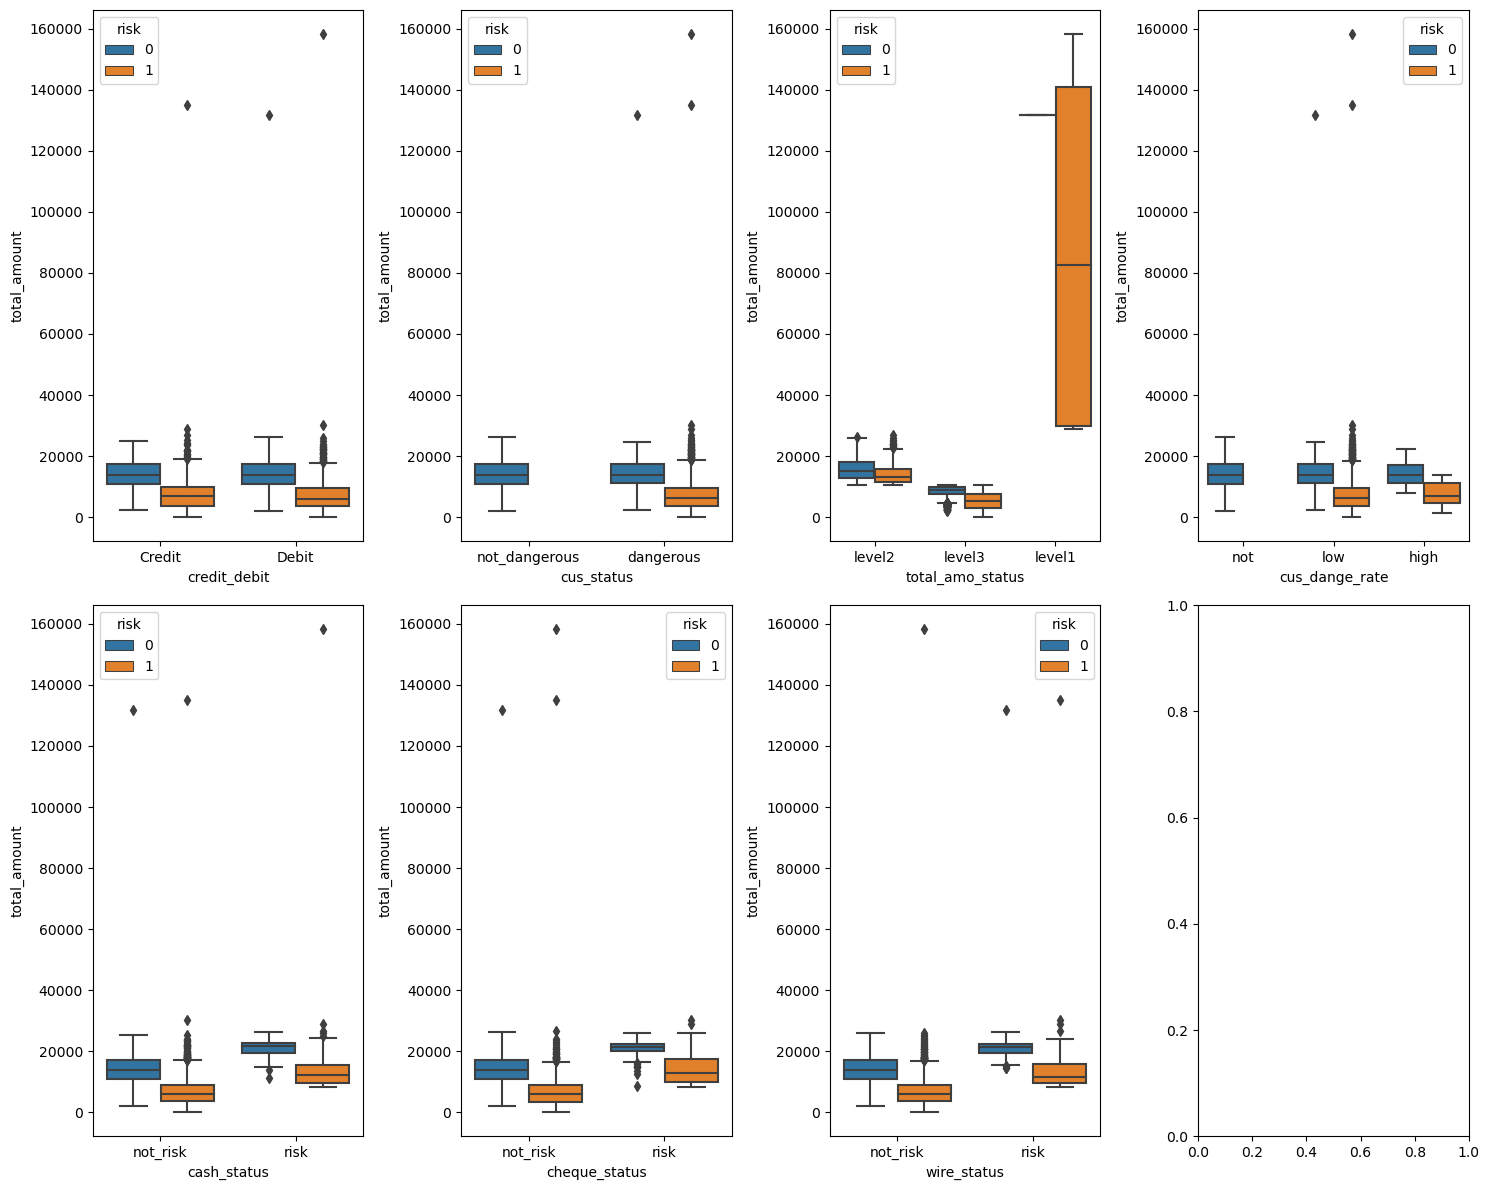

In [25]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(15,12))
axs = axs.flatten()
for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='total_amount', hue='risk', data=table, ax=axs[i])
fig.tight_layout()
plt.show()

<Axes: >

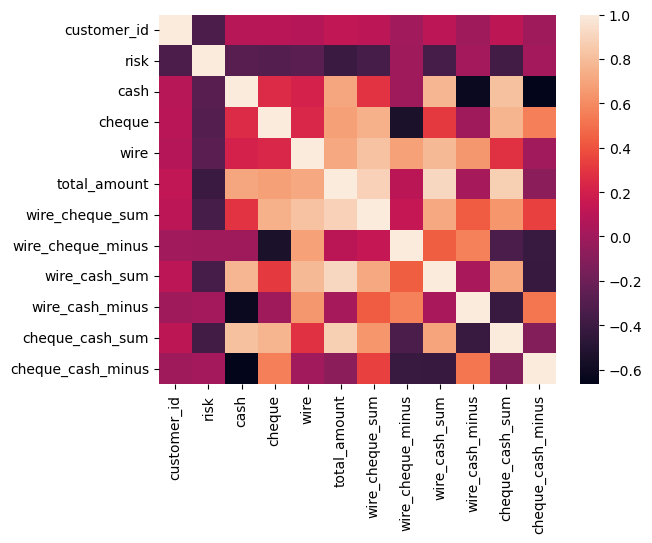

In [26]:
corr = table.corr()
sns.heatmap(corr)

# Encoding

In [27]:
# Except credit_debit variables, all the categorical variables are hierarchic for this reason I use LabelEncoder

cat_cols.remove("credit_debit")
cat_cols


['cus_status',
 'total_amo_status',
 'cus_dange_rate',
 'cash_status',
 'cheque_status',
 'wire_status']

In [28]:
def label_encoder(dataframe, cols):
    labelencoder = LabelEncoder()
    dataframe[cols] = labelencoder.fit_transform(dataframe[cols])
    return dataframe

for col in cat_cols:
    label_encoder(table,col)
table.head()

,customer_id,risk,credit_debit,cash,cheque,wire,cus_status,total_amount,wire_cheque_sum,wire_cheque_minus,wire_cash_sum,wire_cash_minus,cheque_cash_sum,cheque_cash_minus,total_amo_status,cus_dange_rate,cash_status,cheque_status,wire_status
0,0,0,Credit,3574.00,4341.67,4685.75,1,12601.42,9027.42,344.08,8259.75,1111.75,7915.67,767.67,1,2,0,0,0
1,0,0,Debit,3885.20,3302.67,5345.00,1,12532.87,8647.67,2042.33,9230.20,1459.80,7187.87,-582.53,1,2,0,0,0
2,1,0,Credit,5240.00,4560.00,3862.00,1,13662.00,8422.00,-698.00,9102.00,-1378.00,9800.00,-680.00,1,2,0,0,0
3,1,0,Debit,5485.00,5417.00,4205.00,1,15107.00,9622.00,-1212.00,9690.00,-1280.00,10902.00,-68.00,1,2,0,0,0
4,2,0,Credit,4258.50,4525.60,4564.00,1,13348.10,9089.60,38.40,8822.50,305.50,8784.10,267.10,1,2,0,0,0


In [29]:
# Using get_dummies for credit_debit variable
table = pd.get_dummies(table, columns=["credit_debit"], drop_first="True")
table.head()

,customer_id,risk,cash,cheque,wire,cus_status,total_amount,wire_cheque_sum,wire_cheque_minus,wire_cash_sum,wire_cash_minus,cheque_cash_sum,cheque_cash_minus,total_amo_status,cus_dange_rate,cash_status,cheque_status,wire_status,credit_debit_Debit
0,0,0,3574.00,4341.67,4685.75,1,12601.42,9027.42,344.08,8259.75,1111.75,7915.67,767.67,1,2,0,0,0,0
1,0,0,3885.20,3302.67,5345.00,1,12532.87,8647.67,2042.33,9230.20,1459.80,7187.87,-582.53,1,2,0,0,0,1
2,1,0,5240.00,4560.00,3862.00,1,13662.00,8422.00,-698.00,9102.00,-1378.00,9800.00,-680.00,1,2,0,0,0,0
3,1,0,5485.00,5417.00,4205.00,1,15107.00,9622.00,-1212.00,9690.00,-1280.00,10902.00,-68.00,1,2,0,0,0,1
4,2,0,4258.50,4525.60,4564.00,1,13348.10,9089.60,38.40,8822.50,305.50,8784.10,267.10,1,2,0,0,0,0


In [30]:
num_cols.remove("risk")
num_cols

['cash',
 'cheque',
 'wire',
 'total_amount',
 'wire_cheque_sum',
 'wire_cheque_minus',
 'wire_cash_sum',
 'wire_cash_minus',
 'cheque_cash_sum',
 'cheque_cash_minus']

In [31]:
# RobustScaler for numerical variables

table[num_cols] = RobustScaler().fit_transform(table[num_cols])

table.head()

,customer_id,risk,cash,cheque,wire,cus_status,total_amount,wire_cheque_sum,wire_cheque_minus,wire_cash_sum,wire_cash_minus,cheque_cash_sum,cheque_cash_minus,total_amo_status,cus_dange_rate,cash_status,cheque_status,wire_status,credit_debit_Debit
0,0,0,-0.50,-0.18,-0.03,1,-0.12,-0.02,0.27,-0.19,0.90,-0.26,0.62,1,2,0,0,0,0
1,0,0,-0.37,-0.61,0.25,1,-0.13,-0.10,1.61,0.02,1.18,-0.41,-0.47,1,2,0,0,0,1
2,1,0,0.20,-0.09,-0.38,1,0.04,-0.15,-0.55,-0.01,-1.11,0.13,-0.55,1,2,0,0,0,0
3,1,0,0.31,0.27,-0.23,1,0.26,0.10,-0.96,0.11,-1.03,0.36,-0.05,1,2,0,0,0,1
4,2,0,-0.21,-0.10,-0.08,1,-0.00,-0.01,0.03,-0.07,0.25,-0.08,0.21,1,2,0,0,0,0


# Models

### XGBoost

In [32]:

X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)

xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3985
           1       0.94      0.94      0.94       409

    accuracy                           0.99      4394
   macro avg       0.97      0.97      0.97      4394
weighted avg       0.99      0.99      0.99      4394



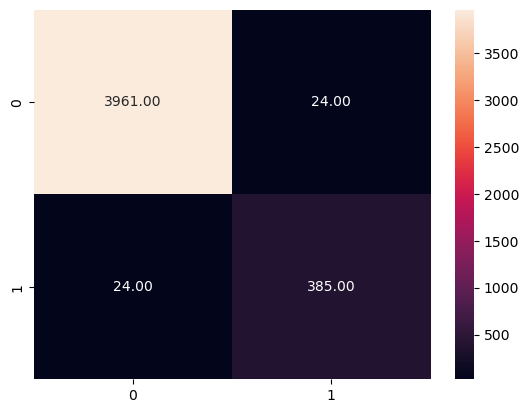

In [33]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.show()

### Random Forest

In [34]:
X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3985
           1       0.94      0.95      0.94       409

    accuracy                           0.99      4394
   macro avg       0.97      0.97      0.97      4394
weighted avg       0.99      0.99      0.99      4394



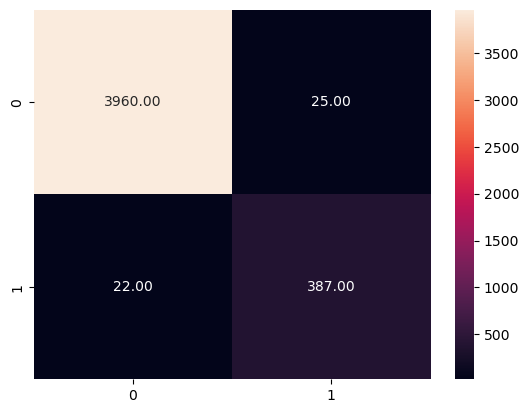

In [35]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.show()

### LightGBM

In [36]:
X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)

lgb_model = LGBMClassifier().fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3985
           1       0.94      0.95      0.94       409

    accuracy                           0.99      4394
   macro avg       0.97      0.97      0.97      4394
weighted avg       0.99      0.99      0.99      4394



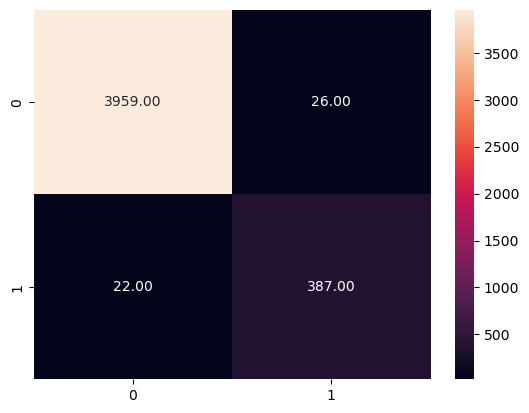

In [37]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.show()

### DecisionTree

In [38]:
X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3985
           1       0.89      0.92      0.91       409

    accuracy                           0.98      4394
   macro avg       0.94      0.96      0.95      4394
weighted avg       0.98      0.98      0.98      4394



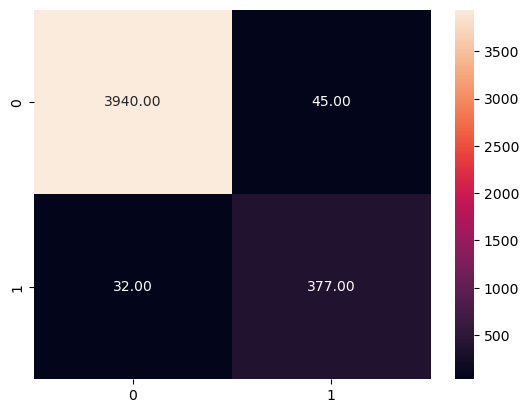

In [39]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.show()

In [40]:
# RandomForest Model Tuning

X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)


rf_cv_model = RandomForestClassifier(max_depth=10, max_features="sqrt", 
                                     min_samples_split=2).fit(X_train, y_train)
y_pred = rf_cv_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3985
           1       0.96      0.93      0.94       409

    accuracy                           0.99      4394
   macro avg       0.97      0.96      0.97      4394
weighted avg       0.99      0.99      0.99      4394



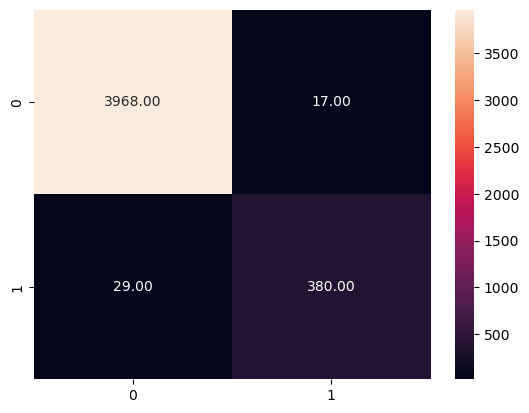

In [41]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')
plt.show()

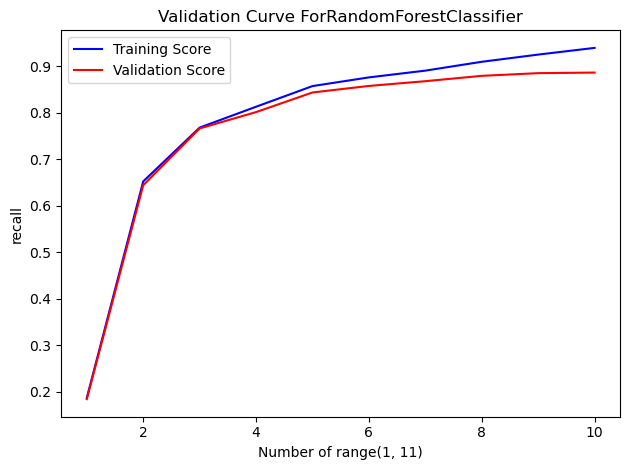

In [42]:
# Validation Curve
def val_score_param(model, X, y, param_name, param_range, scoring='roc_auc', cv=5):
    train_score, test_score = validation_curve(model, X, y, param_name = param_name, param_range = param_range,
                                              scoring = scoring, cv=cv)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score,axis=1)
    
    plt.plot(param_range, mean_train_score, label='Training Score', color='b')
    plt.plot(param_range, mean_test_score, label='Validation Score', color='r')
    
    plt.title(f'Validation Curve For{type(model).__name__}')
    plt.xlabel(f'Number of {param_range}')
    plt.ylabel(f'{scoring}')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
val_score_param(rf_cv_model,X_train,y_train,param_name='max_depth',param_range=range(1,11), scoring='recall', cv=5)

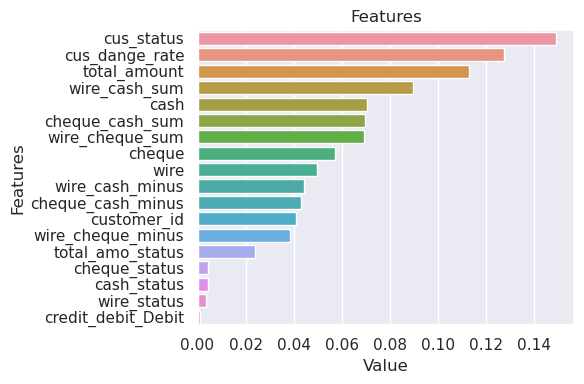

In [43]:
def plot_importance(model, features, num=len(X),save=False):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_, 'Features':features.columns})
    plt.figure(figsize=(6,4))
    sns.set(font_scale=1)
    sns.barplot(x='Value',y='Features',data=feature_imp.sort_values(by='Value',ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importance.png')
plot_importance(rf_cv_model,X)

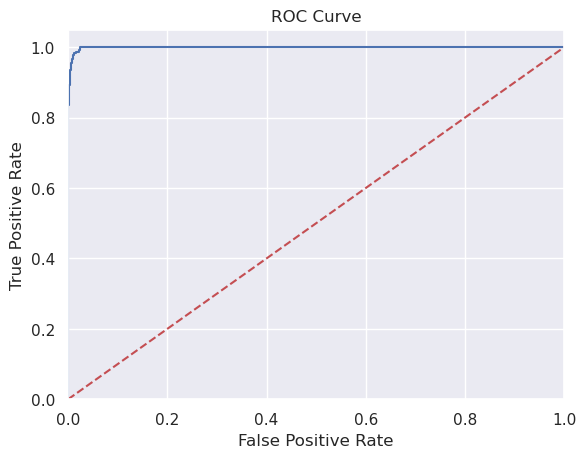

In [44]:
# ROC Graphs

def plot_roc_auc_curve(model):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC (area = %0.2f)" % logit_roc_auc)
    plt.plot([0,1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.show()
plot_roc_auc_curve(rf_cv_model)

In [45]:
# LightGBM Model Tuning

X = table.iloc[:, table.columns != "risk"]
y = table.iloc[:, table.columns == "risk"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1)
lgb_cv_model = LGBMClassifier(learning_rate=0.01, max_depth=10, subsample=0.6, 
                              n_estimators=1000, min_child_samples=10).fit(X_train, y_train)
y_pred = lgb_cv_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3985
           1       0.95      0.95      0.95       409

    accuracy                           0.99      4394
   macro avg       0.97      0.97      0.97      4394
weighted avg       0.99      0.99      0.99      4394



### Model Visualization with Shap(LightGBM)

In [46]:
import shap
shap.initjs()

In [47]:
# Standard Shap Values


shap_values = shap.TreeExplainer(lgb_cv_model).shap_values(X_test)


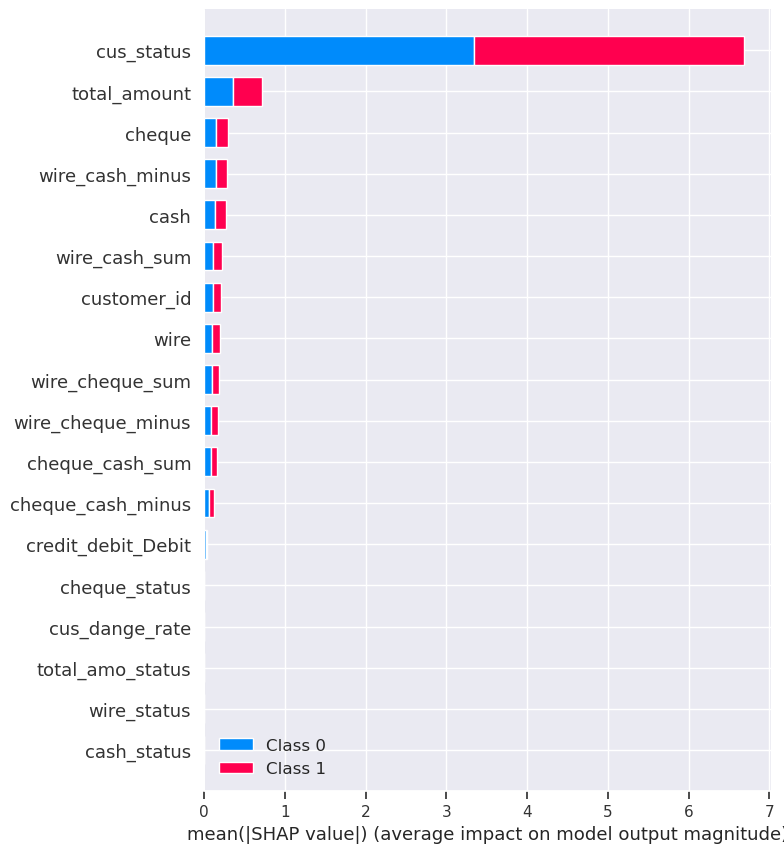

In [48]:
# Summary for model's variables

shap.summary_plot(shap_values, X_test, plot_type="bar")

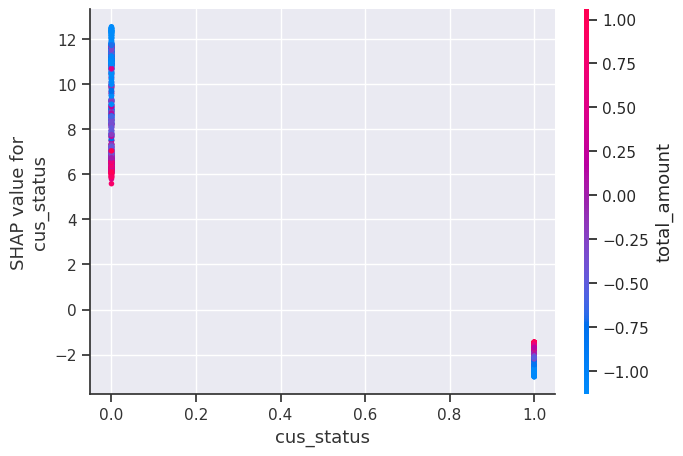

In [49]:
shap.dependence_plot("cus_status", shap_values[1], X_test)

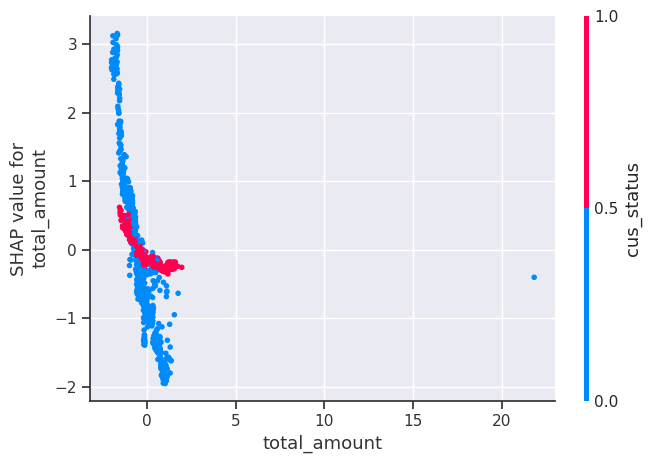

In [50]:
shap.dependence_plot("total_amount", shap_values[1], X_test)

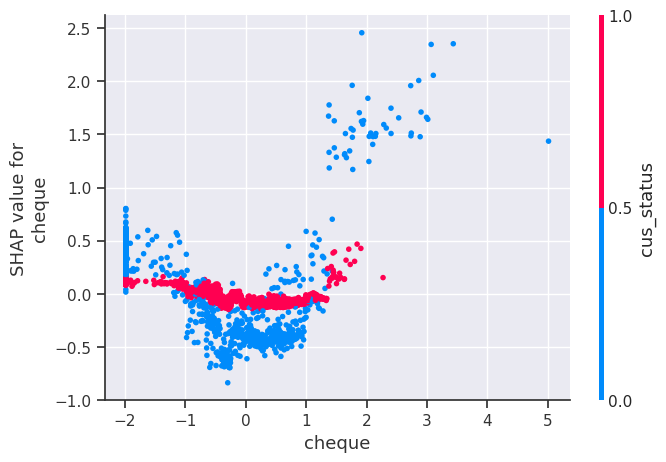

In [51]:
shap.dependence_plot("cheque", shap_values[1], X_test)

In [52]:
from shap import Explainer, Explanation

explainer = Explainer(lgb_cv_model)
shap_values = explainer(X_test)
np.shape(shap_values.values)

(4394, 18, 2)

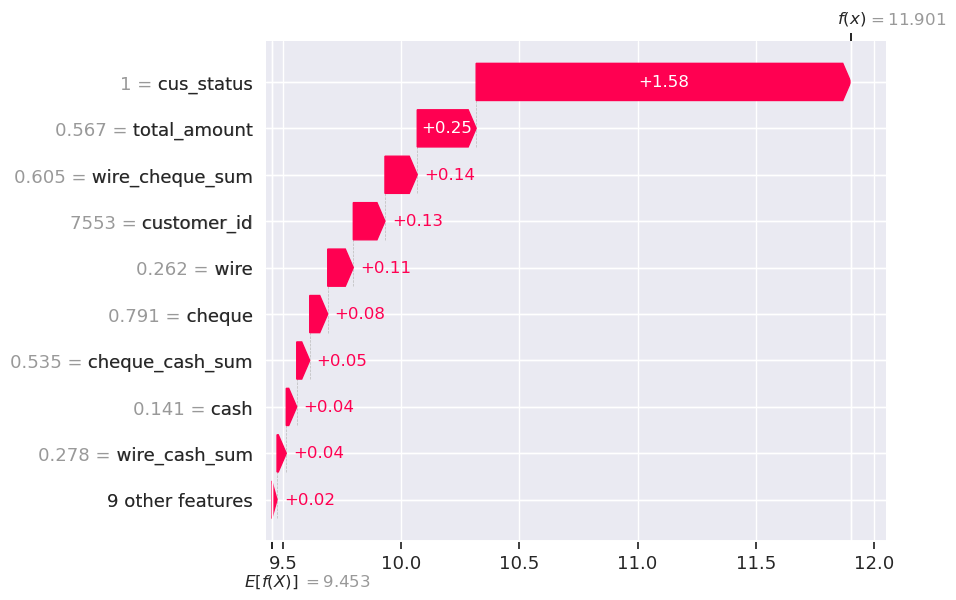

In [53]:
# Features importance with Waterfall Plot

exp = Explanation(shap_values[:,:,0], shap_values.base_values[:,0], X_test, feature_names=X_test.columns)
idx = 1
shap.plots.waterfall(exp[idx])

In [54]:
# Force Plot

shap.plots.force(exp[idx])

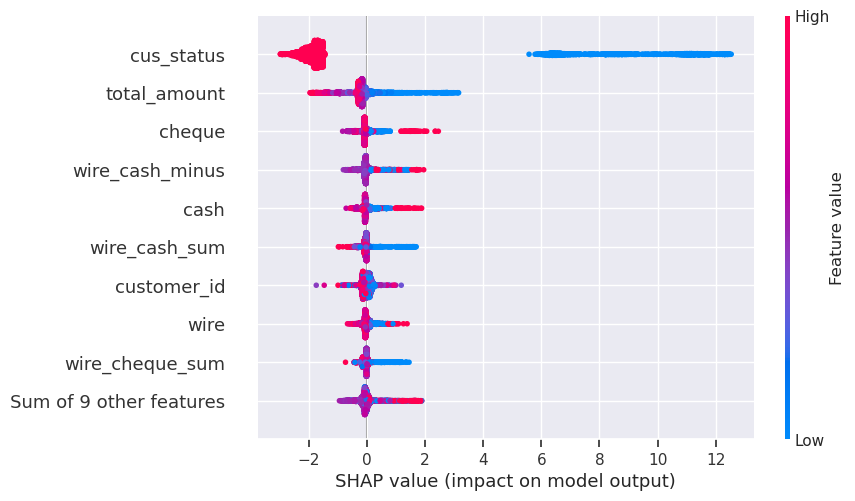

In [55]:
# Beeswarm Plot

shap.plots.beeswarm(shap_values[:,:,1])

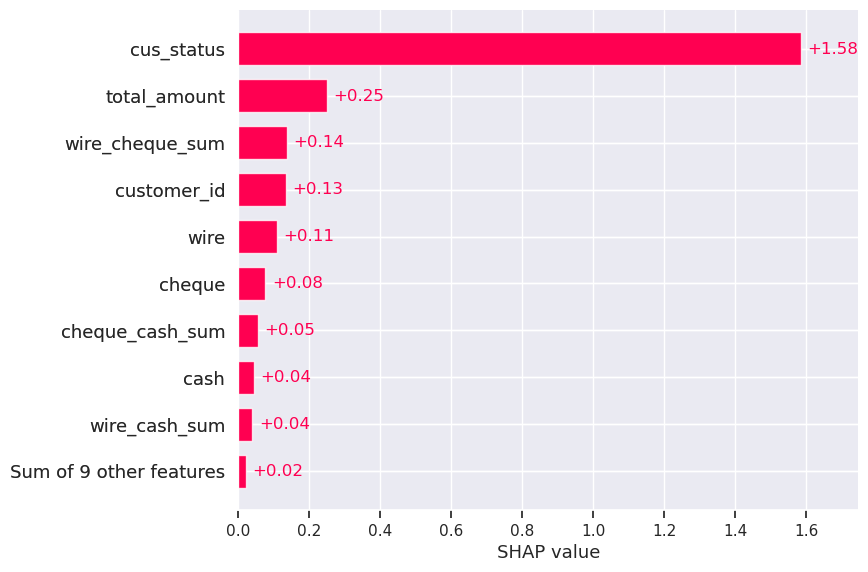

In [56]:
# Absolute Mean Shap

shap.plots.bar(exp[idx])

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Thank you for supports and comments.✌️✌🏿
    </br>
You can follow me and my teammates: </br>
Yunus Emre TURKOGLU: <a href="https://www.linkedin.com/in/yunus-emre-turkoglu/" target="_blank"><font color=white>Visit the Linkedin Profile</font></a> </br>
Veysel ALEVCAN: <a href="https://www.linkedin.com/in/veyselalevcan/" target="_blank"><font color=white>Visit the Linkedin Profile</font></a></br>
Burak DERVISOGLU: <a href="https://www.linkedin.com/in/burak-dervi%C5%9Fo%C4%9Flu-6363aa18b/" target="_blank"><font color=white>Visit the Linkedin Profile</font></a>    </br>
Canan TAMTURK KARA: <a href="https://www.linkedin.com/in/canantamturkkara/" target="_blank"><font color=white>Visit the Linkedin Profile</font></a></br>
Sercan AKI:  <a href="https://www.linkedin.com/in/sercan-aki/" target="_blank"><font color=white>Visit the Linkedin Profile</font></a>
    
</p>
</div>
